# Lambda School Data Science - Recurrent Neural Networks and LSTM

> "Yesterday's just a memory - tomorrow is never what it's supposed to be." -- Bob Dylan

# Lecture

Wish you could save [Time In A Bottle](https://www.youtube.com/watch?v=AnWWj6xOleY)? With statistics you can do the next best thing - understand how data varies over time (or any sequential order), and use the order/time dimension predictively.

A sequence is just any enumerated collection - order counts, and repetition is allowed. Python lists are a good elemental example - `[1, 2, 2, -1]` is a valid list, and is different from `[1, 2, -1, 2]`. The data structures we tend to use (e.g. NumPy arrays) are often built on this fundamental structure.

A time series is data where you have not just the order but some actual continuous marker for where they lie "in time" - this could be a date, a timestamp, [Unix time](https://en.wikipedia.org/wiki/Unix_time), or something else. All time series are also sequences, and for some techniques you may just consider their order and not "how far apart" the entries are (if you have particularly consistent data collected at regular intervals it may not matter).

## Time series with plain old regression

Recurrences are fancy, and we'll get to those later - let's start with something simple. Regression can handle time series just fine if you just set them up correctly - let's try some made-up stock data. And to make it, let's use a few list comprehensions!

In [2]:
import numpy as np
from random import random
days = np.array((range(28)))
stock_quotes = np.array([random() + day * random() for day in days])

In [3]:
stock_quotes

array([ 0.73023986,  1.54746557,  1.27076184,  2.25690247,  0.92322631,
        1.4441809 ,  2.37426699,  7.75643441,  6.75052176,  2.62528293,
        2.91963484,  3.98319333,  3.42739726,  4.13403367,  8.25872925,
       15.36551136,  1.93706943,  9.58033423,  1.60413258,  2.4830768 ,
       14.04414032, 16.85620889, 18.87184183, 13.42749227,  3.7078868 ,
       13.63734999,  6.79024201, 25.11768166])

Let's take a look with a scatter plot:

In [4]:
from matplotlib.pyplot import scatter
scatter(days, stock_quotes)

Looks pretty linear, let's try a simple OLS regression.

First, these need to be NumPy arrays:

In [5]:
days = days.reshape(-1, 1)  # X needs to be column vectors

Now let's use good old `scikit-learn` and linear regression:

In [6]:
from sklearn.linear_model import LinearRegression
ols_stocks = LinearRegression()
ols_stocks.fit(days, stock_quotes)
ols_stocks.score(days, stock_quotes)

0.4577232398253345

That seems to work pretty well, but real stocks don't work like this.

Let's make *slightly* more realistic data that depends on more than just time:

In [7]:
# Not everything is best as a comprehension
stock_data = np.empty([len(days), 4])
for day in days:
  asset = random()
  liability = random()
  quote = random() + ((day * random()) + (20 * asset) - (15 * liability))
  quote = max(quote, 0.01)  # Want positive quotes
  stock_data[day] = np.array([quote, day, asset, liability])

In [8]:
stock_data

array([[1.43149476e+01, 0.00000000e+00, 8.55082212e-01, 2.41099367e-01],
       [1.95105755e+00, 1.00000000e+00, 5.43601219e-01, 6.08445232e-01],
       [7.19218099e+00, 2.00000000e+00, 2.93793114e-01, 5.04354910e-02],
       [9.45017057e+00, 3.00000000e+00, 9.87775031e-01, 7.93331857e-01],
       [2.99023585e-01, 4.00000000e+00, 7.29380478e-02, 3.85941117e-01],
       [1.00000000e-02, 5.00000000e+00, 3.07374452e-02, 4.86361323e-01],
       [1.31713670e+01, 6.00000000e+00, 6.34825392e-01, 3.92589678e-01],
       [7.44711035e+00, 7.00000000e+00, 7.42394183e-01, 6.46135168e-01],
       [7.57430936e+00, 8.00000000e+00, 6.27585786e-01, 6.89711562e-01],
       [1.47836301e+01, 9.00000000e+00, 7.06540805e-01, 2.60190147e-02],
       [9.33323387e+00, 1.00000000e+01, 1.24356507e-01, 3.20477352e-02],
       [1.00000000e-02, 1.10000000e+01, 2.37409997e-01, 6.13287829e-01],
       [1.81778573e+01, 1.20000000e+01, 7.97952399e-01, 3.89570682e-01],
       [5.49479652e+00, 1.30000000e+01, 6.11608759e

Let's look again:

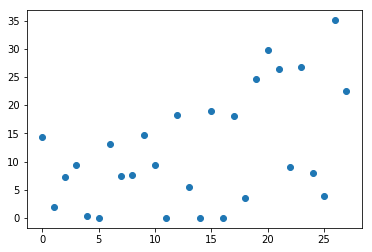

In [9]:
stock_quotes = stock_data[:,0]
scatter(days, stock_quotes)

How does our old model do?

In [10]:
days = np.array(days).reshape(-1, 1)
ols_stocks.fit(days, stock_quotes)
ols_stocks.score(days, stock_quotes)

0.2459279604173189

Not bad, but can we do better?

In [11]:
ols_stocks.fit(stock_data[:,1:], stock_quotes)
ols_stocks.score(stock_data[:,1:], stock_quotes)

0.8274622990636692

Yep - unsurprisingly, the other covariates (assets and liabilities) have info.

But, they do worse without the day data.

In [12]:
ols_stocks.fit(stock_data[:,2:], stock_quotes)
ols_stocks.score(stock_data[:,2:], stock_quotes)

0.704822045041411

## Time series jargon

There's a lot of semi-standard language and tricks to talk about this sort of data. [NIST](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm) has an excellent guidebook, but here are some highlights:

### Moving average

Moving average aka rolling average aka running average.

Convert a series of data to a series of averages of continguous subsets:

In [13]:
stock_quotes_rolling = [sum(stock_quotes[i:i+3]) / 3
                        for i in range(len(stock_quotes - 2))]
stock_quotes_rolling

[7.819395392005422,
 6.197803037318266,
 5.647125047790104,
 3.2530647193049362,
 4.493463530230145,
 6.876159119728457,
 9.397595573346733,
 9.935016602139305,
 10.56372444087427,
 8.042287987255994,
 9.17369704767247,
 7.894217932853661,
 7.894217932853661,
 8.183902862111069,
 6.35563735382576,
 12.379511348135559,
 7.220011141972043,
 15.419733666758006,
 19.335229342832932,
 26.96414548400387,
 21.784246372641892,
 20.74786154435367,
 14.60478380349444,
 12.890131216023578,
 15.665346041848238,
 20.478118692039384,
 19.169614532752924,
 7.488081531498435]

Pandas has nice series related functions:

In [14]:
import pandas as pd
df = pd.DataFrame(stock_quotes)
df.rolling(3).mean()

,0
0,NaN
1,NaN
2,7.819395
3,6.197803
4,5.647125
5,3.253065
6,4.493464
7,6.876159
8,9.397596
9,9.935017


### Forecasting

Forecasting - at it's simplest, it just means "predict the future":

In [15]:
ols_stocks.fit(stock_data[:,1:], stock_quotes)
ols_stocks.predict([[29, 0.5, 0.5]])

array([16.71290196])

One way to predict if you just have the series data is to use the prior observation. This can be pretty good (if you had to pick one feature to model the temperature for tomorrow, the temperature today is a good choice).

In [16]:
temperature = np.array([30 + random() * day
                        for day in np.array(range(365)).reshape(-1, 1)])
print(temperature.shape)
temperature_next = temperature[1:].reshape(-1, 1)
temperature_ols = LinearRegression()
temperature_ols.fit(temperature[:-1], temperature_next)
temperature_ols.score(temperature[:-1], temperature_next)

(365, 1)


0.1795559563974789

But you can often make it better by considering more than one prior observation.

In [17]:
temperature_next_next = temperature[2:].reshape(-1, 1)
temperature_two_past = np.concatenate([temperature[:-2], temperature_next[:-1]],
                                      axis=1)
temperature_ols.fit(temperature_two_past, temperature_next_next)
temperature_ols.score(temperature_two_past, temperature_next_next)

0.20088930247461934

### Exponential smoothing

Exponential smoothing means using exponentially decreasing past weights to predict the future.

You could roll your own, but let's use Pandas.

In [18]:
temperature_df = pd.DataFrame(temperature)
temperature_df.ewm(halflife=7).mean()

,0
0,30.000000
1,30.147716
2,30.120416
3,30.588377
4,31.255489
5,31.953986
6,32.362786
7,32.052450
8,32.983263
9,32.573327


Halflife is among the parameters we can play with:

In [19]:
sse_1 = ((temperature_df - temperature_df.ewm(halflife=7).mean())**2).sum()
sse_2 = ((temperature_df - temperature_df.ewm(halflife=3).mean())**2).sum()
print(sse_1)
print(sse_2)

0    1.204091e+06
dtype: float64
0    992657.871928
dtype: float64


Note - the first error being higher doesn't mean it's necessarily *worse*. It's *smoother* as expected, and if that's what we care about - great!

### Seasonality

Seasonality - "day of week"-effects, and more. In a lot of real world data, certain time periods are systemically different, e.g. holidays for retailers, weekends for restaurants, seasons for weather.

Let's try to make some seasonal data - a store that sells more later in a week:

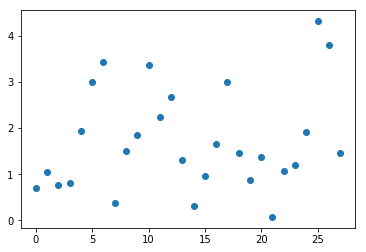

In [20]:
sales = np.array([random() + (day % 7) * random() for day in days])
scatter(days, sales)

How does linear regression do at fitting this?

In [21]:
sales_ols = LinearRegression()
sales_ols.fit(days, sales)
sales_ols.score(days, sales)

0.031681248136330664

That's not great - and the fix depends on the domain. Here, we know it'd be best to actually use "day of week" as a feature.

In [22]:
day_of_week = days % 7
sales_ols.fit(day_of_week, sales)
sales_ols.score(day_of_week, sales)

0.31544481424197157

Note that it's also important to have representative data across whatever seasonal feature(s) you use - don't predict retailers based only on Christmas, as that won't generalize well.

## Recurrent Neural Networks

There's plenty more to "traditional" time series, but the latest and greatest technique for sequence data is recurrent neural networks. A recurrence relation in math is an equation that uses recursion to define a sequence - a famous example is the Fibonacci numbers:

$F_n = F_{n-1} + F_{n-2}$

For formal math you also need a base case $F_0=1, F_1=1$, and then the rest builds from there. But for neural networks what we're really talking about are loops:

![Recurrent neural network](https://upload.wikimedia.org/wikipedia/commons/b/b5/Recurrent_neural_network_unfold.svg)

The hidden layers have edges (output) going back to their own input - this loop means that for any time `t` the training is at least partly based on the output from time `t-1`. The entire network is being represented on the left, and you can unfold the network explicitly to see how it behaves at any given `t`.

Different units can have this "loop", but a particularly successful one is the long short-term memory unit (LSTM):

![Long short-term memory unit](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Long_Short-Term_Memory.svg/1024px-Long_Short-Term_Memory.svg.png)

There's a lot going on here - in a nutshell, the calculus still works out and backpropagation can still be implemented. The advantage (ane namesake) of LSTM is that it can generally put more weight on recent (short-term) events while not completely losing older (long-term) information.

After enough iterations, a typical neural network will start calculating prior gradients that are so small they effectively become zero - this is the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), and is what RNN with LSTM addresses. Pay special attention to the $c_t$ parameters and how they pass through the unit to get an intuition for how this problem is solved.

So why are these cool? One particularly compelling application is actually not time series but language modeling - language is inherently ordered data (letters/words go one after another, and the order *matters*). [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) is a famous and worth reading blog post on this topic.

For our purposes, let's use TensorFlow and Keras to train RNNs with natural language. Resources:

- https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py
- https://keras.io/layers/recurrent/#lstm
- http://adventuresinmachinelearning.com/keras-lstm-tutorial/

Note that `tensorflow.contrib` [also has an implementation of RNN/LSTM](https://www.tensorflow.org/tutorials/sequences/recurrent).

### RNN/LSTM Sentiment Classification with Keras

In [36]:
'''
#Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
**Notes**
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 100s 4ms/step - loss: 0.4604 - acc: 0.7822 - val_loss: 0.3945 - val_acc: 0.8254
Epoch 2/15
25000/25000 [==============================] - 93s 4ms/step - loss: 0.3024 - acc: 0.8748 - val_loss: 0.3847 - val_acc: 0.8334
Epoch 3/15
25000/25000 [==============================] - 97s 4ms/step - loss: 0.2186 - acc: 0.9149 - val_loss: 0.4092 - val_acc: 0.8220
Epoch 4/15
25000/25000 [==============================] - 99s 4ms/step - loss: 0.1582 - acc: 0.9396 - val_loss: 0.4461 - val_acc: 0.8246
Epoch 5/15
25000/25000 [==============================] - 99s 4ms/step - loss: 0.1132 - acc: 0.9590 - val_loss: 0.6879 - val_acc: 0.8116
Epoch 6/15
25000/25000 [==============================] - 99s 4ms/step - loss: 0.0823 - acc: 0.97

### RNN Text generation with NumPy

What else can we do with RNN? Since we're analyzing the *sequence*, we can do more than classify - we can *generate* text. We'll pull some news stories using [newspaper](https://github.com/codelucas/newspaper/).

#### Initialization

In [24]:
!pip install newspaper3k

    100% |████████████████████████████████| 215kB 947kB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 2.3MB/s ta 0:00:011
    100% |████████████████████████████████| 194kB 7.1MB/s ta 0:00:01
    100% |████████████████████████████████| 7.4MB 1.1MB/s ta 0:00:011
  Stored in directory: /home/mark/.cache/pip/wheels/81/2b/43/a02ede72324dd40cdd7ca53aad718c7710628e91b8b0dc0f02
  Stored in directory: /home/mark/.cache/pip/wheels/8c/69/b7/f52763c41c5471df57703a0ef718a32a5e81ee35dcf6d4f97f
  Stored in directory: /home/mark/.cache/pip/wheels/de/03/ca/778e3a7a627e3d98836cc890e7cb40c7575424cfd3340f40ed
  Stored in directory: /home/mark/.cache/pip/wheels/83/15/9c/a3f1f67e7f7181170ad37d32e503c35da20627c013f438ed34
Successfully built tinysegmenter feedparser feedfinder2 jieba3k


In [37]:
import newspaper

In [38]:
ap = newspaper.build('https://www.apnews.com')
len(ap.articles)

5

In [39]:
article_text = ''

for article in ap.articles[:1]:
  try:
    article.download()
    article.parse()
    article_text += '\n\n' + article.text
  except:
    print('Failed: ' + article.url)
  
article_text = article_text.split('\n\n')[1]
print(article_text)

CAIRO — Egyptian President Abdel-Fattah el-Sissi has a much sought-after White House summit Tuesday, hoping it will confer a new level of legitimacy on his presidency as he seeks to cement his hold on power and, human rights groups say, silence any domestic critics who stand in his way.


In [40]:
# Based on "The Unreasonable Effectiveness of RNN" implementation
import numpy as np

chars = list(set(article_text)) # split and remove duplicate characters. convert to list.

num_chars = len(chars) # the number of unique characters
txt_data_size = len(article_text)

print("unique characters : ", num_chars)
print("txt_data_size : ", txt_data_size)

unique characters :  39
txt_data_size :  287


In [41]:
# one hot encode
char_to_int = dict((c, i) for i, c in enumerate(chars)) # "enumerate" retruns index and value. Convert it to dictionary
int_to_char = dict((i, c) for i, c in enumerate(chars))
print(char_to_int)
print("----------------------------------------------------")
print(int_to_char)
print("----------------------------------------------------")
# integer encode input data
integer_encoded = [char_to_int[i] for i in article_text] # "integer_encoded" is a list which has a sequence converted from an original data to integers.
print(integer_encoded)
print("----------------------------------------------------")
print("data length : ", len(integer_encoded))

{'w': 0, ' ': 1, 'i': 2, 'H': 3, 'F': 4, 'b': 5, 'e': 6, 'f': 7, 'm': 8, 'A': 9, 'd': 10, 'v': 11, 'l': 12, 'P': 13, 'S': 14, 'g': 15, 'R': 16, 'E': 17, 'T': 18, 'O': 19, 'n': 20, 'p': 21, 't': 22, 'c': 23, 'y': 24, 's': 25, 'u': 26, '.': 27, 'r': 28, 'W': 29, ',': 30, 'h': 31, 'o': 32, 'k': 33, 'a': 34, 'I': 35, '—': 36, 'C': 37, '-': 38}
----------------------------------------------------
{0: 'w', 1: ' ', 2: 'i', 3: 'H', 4: 'F', 5: 'b', 6: 'e', 7: 'f', 8: 'm', 9: 'A', 10: 'd', 11: 'v', 12: 'l', 13: 'P', 14: 'S', 15: 'g', 16: 'R', 17: 'E', 18: 'T', 19: 'O', 20: 'n', 21: 'p', 22: 't', 23: 'c', 24: 'y', 25: 's', 26: 'u', 27: '.', 28: 'r', 29: 'W', 30: ',', 31: 'h', 32: 'o', 33: 'k', 34: 'a', 35: 'I', 36: '—', 37: 'C', 38: '-'}
----------------------------------------------------
[37, 9, 35, 16, 19, 1, 36, 1, 17, 15, 24, 21, 22, 2, 34, 20, 1, 13, 28, 6, 25, 2, 10, 6, 20, 22, 1, 9, 5, 10, 6, 12, 38, 4, 34, 22, 22, 34, 31, 1, 6, 12, 38, 14, 2, 25, 25, 2, 1, 31, 34, 25, 1, 34, 1, 8, 26, 23

In [42]:
# hyperparameters

iteration = 1000
sequence_length = 40
batch_size = round((txt_data_size /sequence_length)+0.5) # = math.ceil
hidden_size = 500  # size of hidden layer of neurons.  
learning_rate = 1e-1


# model parameters

W_xh = np.random.randn(hidden_size, num_chars)*0.01     # weight input -> hidden. 
W_hh = np.random.randn(hidden_size, hidden_size)*0.01   # weight hidden -> hidden
W_hy = np.random.randn(num_chars, hidden_size)*0.01     # weight hidden -> output

b_h = np.zeros((hidden_size, 1)) # hidden bias
b_y = np.zeros((num_chars, 1)) # output bias

h_prev = np.zeros((hidden_size,1)) # h_(t-1)

#### Forward propagation

In [43]:
def forwardprop(inputs, targets, h_prev):
        
    # Since the RNN receives the sequence, the weights are not updated during one sequence.
    xs, hs, ys, ps = {}, {}, {}, {} # dictionary
    hs[-1] = np.copy(h_prev) # Copy previous hidden state vector to -1 key value.
    loss = 0 # loss initialization
    
    for t in range(len(inputs)): # t is a "time step" and is used as a key(dic).  
        
        xs[t] = np.zeros((num_chars,1)) 
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(W_xh, xs[t]) + np.dot(W_hh, hs[t-1]) + b_h) # hidden state. 
        ys[t] = np.dot(W_hy, hs[t]) + b_y # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars. 
        # Softmax. -> The sum of probabilities is 1 even without the exp() function, but all of the elements are positive through the exp() function.
 
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss). Efficient and simple code

#         y_class = np.zeros((num_chars, 1)) 
#         y_class[targets[t]] =1
#         loss += np.sum(y_class*(-np.log(ps[t]))) # softmax (cross-entropy loss)        

    return loss, ps, hs, xs

#### Backward propagation

In [44]:
def backprop(ps, inputs, hs, xs):

    dWxh, dWhh, dWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy) # make all zero matrices.
    dbh, dby = np.zeros_like(b_h), np.zeros_like(b_y)
    dhnext = np.zeros_like(hs[0]) # (hidden_size,1) 

    # reversed
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t]) # shape (num_chars,1).  "dy" means "dloss/dy"
        dy[targets[t]] -= 1 # backprop into y. After taking the soft max in the input vector, subtract 1 from the value of the element corresponding to the correct label.
        dWhy += np.dot(dy, hs[t].T)
        dby += dy 
        dh = np.dot(W_hy.T, dy) + dhnext # backprop into h. 
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity #tanh'(x) = 1-tanh^2(x)
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(W_hh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]: 
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients.  
    
    return dWxh, dWhh, dWhy, dbh, dby

#### Training

In [45]:
%%time

data_pointer = 0

# memory variables for Adagrad
mWxh, mWhh, mWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy)
mbh, mby = np.zeros_like(b_h), np.zeros_like(b_y) 

for i in range(iteration):
    h_prev = np.zeros((hidden_size,1)) # reset RNN memory
    data_pointer = 0 # go from start of data
    
    for b in range(batch_size):
        
        inputs = [char_to_int[ch] for ch in article_text[data_pointer:data_pointer+sequence_length]]
        targets = [char_to_int[ch] for ch in article_text[data_pointer+1:data_pointer+sequence_length+1]] # t+1        
            
        if (data_pointer+sequence_length+1 >= len(article_text) and b == batch_size-1): # processing of the last part of the input data. 
#             targets.append(char_to_int[txt_data[0]])   # When the data doesn't fit, add the first char to the back.
            targets.append(char_to_int[" "])   # When the data doesn't fit, add space(" ") to the back.


        # forward
        loss, ps, hs, xs = forwardprop(inputs, targets, h_prev)
#         print(loss)
    
        # backward
        dWxh, dWhh, dWhy, dbh, dby = backprop(ps, inputs, hs, xs) 
        
        
    # perform parameter update with Adagrad
        for param, dparam, mem in zip([W_xh, W_hh, W_hy, b_h, b_y], 
                                    [dWxh, dWhh, dWhy, dbh, dby], 
                                    [mWxh, mWhh, mWhy, mbh, mby]):
            mem += dparam * dparam # elementwise
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update      
    
        data_pointer += sequence_length # move data pointer
        
    if i % 100 == 0:
        print ('iter %d, loss: %f' % (i, loss)) # print progress

iter 0, loss: 143.305485
iter 100, loss: 10.645549
iter 200, loss: 13.384007
iter 300, loss: 13.169243
iter 400, loss: 8.382250
iter 500, loss: 9.199066
iter 600, loss: 9.163723
iter 700, loss: 8.371003
iter 800, loss: 7.495002
iter 900, loss: 6.928444
CPU times: user 10min 39s, sys: 0 ns, total: 10min 39s
Wall time: 2min 40s


#### Prediction

In [46]:
def predict(test_char, length):
    x = np.zeros((num_chars, 1)) 
    x[char_to_int[test_char]] = 1
    ixes = []
    h = np.zeros((hidden_size,1))

    for t in range(length):
        h = np.tanh(np.dot(W_xh, x) + np.dot(W_hh, h) + b_h) 
        y = np.dot(W_hy, h) + b_y
        p = np.exp(y) / np.sum(np.exp(y)) 
        ix = np.random.choice(range(num_chars), p=p.ravel()) # ravel -> rank0
        # "ix" is a list of indexes selected according to the soft max probability.
        x = np.zeros((num_chars, 1)) # init
        x[ix] = 1 
        ixes.append(ix) # list
    txt = test_char + ''.join(int_to_char[i] for i in ixes)
    print ('----\n %s \n----' % (txt, ))

In [49]:
predict('C', 50)

----
 CAIRO hdsoemomiypir  wlcsaieh Hnpoto. siai sin  cy  
----


Well... that's *vaguely* language-looking. Can you do better?

# Assignment

![Monkey at a typewriter](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3c/Chimpanzee_seated_at_typewriter.jpg/603px-Chimpanzee_seated_at_typewriter.jpg)

It is said that [infinite monkeys typing for an infinite amount of time](https://en.wikipedia.org/wiki/Infinite_monkey_theorem) will eventually type, among other things, the complete works of Wiliam Shakespeare. Let's see if we can get there a bit faster, with the power of Recurrent Neural Networks and LSTM.

This text file contains the complete works of Shakespeare: https://www.gutenberg.org/files/100/100-0.txt

Use it as training data for an RNN - you can keep it simple and train character level, and that is suggested as an initial approach.

Then, use that trained RNN to generate Shakespearean-ish text. Your goal - a function that can take, as an argument, the size of text (e.g. number of characters or lines) to generate, and returns generated text of that size.

Note - Shakespeare wrote an awful lot. It's OK, especially initially, to sample/use smaller data and parameters, so you can have a tighter feedback loop when you're trying to get things running. Then, once you've got a proof of concept - start pushing it more!

In [ ]:
# TODO - Words, words, mere words, no matter from the heart.

In [143]:
import requests
url = "https://www.gutenberg.org/files/100/100-0.txt"
text = requests.get(url).text


In [144]:
import re
pn = [m.span() for m in re.finditer(r" (\d{1,3})\r\n", text)]

In [145]:
def get_sonnent(n, ton=-1):
    if ton == -1:
        ton = n
    return text[pn[n - 1][0]:pn[ton][0]]

In [146]:
print(get_sonnent(2,4))

 2

When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty’s field,
Thy youth’s proud livery so gazed on now,
Will be a tattered weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv’d thy beauty’s use,
If thou couldst answer ‘This fair child of mine
Shall sum my count, and make my old excuse,’
Proving his beauty by succession thine.
  This were to be new made when thou art old,
  And see thy blood warm when thou feel’st it cold.


                    3

Look in thy glass and tell the face thou viewest,
Now is the time that face should form another,
Whose fresh repair if now thou not renewest,
Thou dost beguile the world, unbless some mother.
For where is she so fair whose uneared womb
Disdains the tillage of thy husbandry?
Or who is he so fond will be the tomb
Of his self-love to stop 

In [115]:
!pip install textgenrnn

    100% |████████████████████████████████| 1.7MB 2.0MB/s ta 0:00:011
  Stored in directory: /home/mark/.cache/pip/wheels/23/46/b0/4444949d8310e43e273e931cfa9e175c34b7a2349c8114a6f7
Successfully built textgenrnn


In [147]:
from textgenrnn import textgenrnn

In [148]:
textgen = textgenrnn()

In [124]:
dir(textgen)

['META_TOKEN',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'config',
 'default_config',
 'encode_text_vectors',
 'generate',
 'generate_samples',
 'generate_to_file',
 'indices_char',
 'load',
 'model',
 'num_classes',
 'reset',
 'save',
 'similarity',
 'tokenizer',
 'train_from_file',
 'train_from_largetext_file',
 'train_new_model',
 'train_on_texts',
 'vocab']

In [165]:
textgen.train_new_model(get_sonnent(1,10),dropout=0.1)

Training new model w/ 2-layer, 128-cell LSTMs
Training on 13,184 character sequences.
Epoch 1/50
103/103 [==============================] - 3s 32ms/step - loss: 1.7948
####################
Temperature: 0.2
####################
 

 

 

####################
Temperature: 0.5
####################
 

c

 

####################
Temperature: 1.0
####################
n

s

u

Epoch 2/50
103/103 [==============================] - 2s 20ms/step - loss: 1.5645
####################
Temperature: 0.2
####################
 

 

 

####################
Temperature: 0.5
####################
s

s

 

####################
Temperature: 1.0
####################
 



m

Epoch 3/50
103/103 [==============================] - 2s 21ms/step - loss: 1.5585
####################
Temperature: 0.2
####################
 

 

 

####################
Temperature: 0.5
####################
 

 

e

####################
Temperature: 1.0
####################
A

o

f

Epoch 4/50
103/103 [==============================] - 2s 

####################
Temperature: 0.2
####################
 

 

 

####################
Temperature: 0.5
####################
 

e

 

####################
Temperature: 1.0
####################
 

a

t

Epoch 30/50
103/103 [==============================] - 2s 19ms/step - loss: 1.5487
####################
Temperature: 0.2
####################
e

 

 

####################
Temperature: 0.5
####################
e

 

e

####################
Temperature: 1.0
####################
e

e

s

Epoch 31/50
103/103 [==============================] - 2s 19ms/step - loss: 1.5486
####################
Temperature: 0.2
####################
 

 

 

####################
Temperature: 0.5
####################
 

h

 

####################
Temperature: 1.0
####################
t

o

n

Epoch 32/50
103/103 [==============================] - 2s 19ms/step - loss: 1.5488
####################
Temperature: 0.2
####################
 

 

 

####################
Temperature: 0.5
####################
 

 

 

###

In [166]:
textgen.generate(5)

100%|██████████| 5/5 [00:00<00:00, 132.62it/s]

e

 

h

e

r



In [150]:
textgen_2 = textgenrnn(weights_path='textgenrnn_weights.hdf5',
                       vocab_path='textgenrnn_vocab.json',
                       config_path='textgenrnn_config.json')

In [155]:
textgen_2.generate(5)

100%|██████████| 5/5 [00:00<00:00, 247.86it/s]

sonnent

sonnent

sonnent

sonnent

sonnent



In [153]:
textgen_2.generate_samples()

####################
Temperature: 0.2
####################
 

 

 

####################
Temperature: 0.5
####################



 

 

####################
Temperature: 1.0
####################
 

o

’



In [152]:
?textgen.train_new_model

In [161]:
textgen.reset()
textgen.train_from_file('output.txt',
                        new_model=True,
                        rnn_bidirectional=True,
                        rnn_size=64,
                        dim_embeddings=300,
                        num_epochs=1)

180 texts collected.
Training new model w/ 2-layer, 64-cell Bidirectional LSTMs
Training on 6,410 character sequences.
Epoch 1/1
50/50 [==============================] - 3s 59ms/step - loss: 3.1068
####################
Temperature: 0.2
####################
      lthee the tinon   the the toneange,

  lthe theel the theellore e thelthellsthe  then one   the the theay theong the the oned the theloy   theseare,

    the   thon the there othe thingong the the theange,

####################
Temperature: 0.5
####################
Tororeefed angye tny festherineron theelloemed o .

Thinhy  tthin braran tholl thotouslll:

Te  tho thintoy theoonouo theistes the,

####################
Temperature: 1.0
####################
dteeey?

Soouy wryburinuw wwkovefra o.

The.



In [163]:
textgen.generate(50)

  4%|▍         | 2/50 [00:00<00:04, 11.14it/s]



wheemeerel   proAe,

Fo  loree,



 12%|█▏        | 6/50 [00:00<00:05,  7.55it/s]

    d  tingenhed theroone therery thusthroonoure tour thin tty  uon windallor  tereleongde,



The y   he tind se  stheere,



 16%|█▌        | 8/50 [00:01<00:08,  4.97it/s]

Whe ou theelnther  the w  thanotnhelntheinthhounl thre tpreeothey  tere be,

See y thed toorel:



 18%|█▊        | 9/50 [00:01<00:09,  4.45it/s]

u thy  tare outhereaan ty   the thelels gle,

Bin ino res 



 22%|██▏       | 11/50 [00:02<00:10,  3.65it/s]

The de  d  wnin ’ thonely  tingeinth on llonweled thothefored thee woorethelangotthemouty  ollleme,



 24%|██▍       | 12/50 [00:02<00:11,  3.42it/s]

S   honethe  he y  tlon tintorel  theangne tthea.



 30%|███       | 15/50 [00:03<00:09,  3.75it/s]

     theme oung  os    twerereonmell thepinohy  harered  belowe,

illoBe  2ron

     thelthond  be,



 32%|███▏      | 16/50 [00:04<00:10,  3.13it/s]

    o  t ore be nothheothed   than thouney  tthoond ting he wtheeson winteanthe ds  llondtheare,



 34%|███▍      | 17/50 [00:04<00:11,  2.82it/s]

The we thon oy    th3o  y    be whe rongengeearerforen  te t ongy  tunthpan :









 44%|████▍     | 22/50 [00:05<00:06,  4.00it/s]

Thellorein  wing uthone gorellloG thinthare l therealll 4e,

che langthe  sthoforfongonge





 48%|████▊     | 24/50 [00:05<00:05,  4.59it/s]

Oo  dtheked sthel theonge there ’sthean dke,



 56%|█████▌    | 28/50 [00:06<00:05,  4.30it/s]

Whorun  on   l thoy thouseindy  tinelus ufenhereond  athe thdd tbreeringy ongin ce,



Whe he   the,

f   pare,

ehoose woun oon inged wouthed thind lge the  thebeseprerethele,



 60%|██████    | 30/50 [00:06<00:05,  3.89it/s]

 o  g hey   pere  on thestheme lray pan  llld  thereeseooundfos donteme,



 62%|██████▏   | 31/50 [00:06<00:05,  3.74it/s]

   the winthme  vee lingathe oresoreton  rore,



 66%|██████▌   | 33/50 [00:07<00:04,  4.05it/s]

o   one  whelingeperus toreld thelonwonorindthe e.

The wingworeke  mere,



 72%|███████▏  | 36/50 [00:07<00:02,  5.91it/s]

Be tn  tig   the.

 

S   sthethe ealomee e,









 80%|████████  | 40/50 [00:07<00:01,  7.61it/s]

O  ldoute thllothy twon o,

Bu the ty   lothaleapeseas tThoningely ty thaothe.



 84%|████████▍ | 42/50 [00:08<00:01,  5.77it/s]

   te wivhe oes   thue tos  thethe tou troundels lthvee,





 88%|████████▊ | 44/50 [00:08<00:00,  6.21it/s]

    the whe peelon  t thmy  y d oreloy   orene,



 90%|█████████ | 45/50 [00:09<00:01,  3.57it/s]

A   theeserehearveremeeaestemin oheagforohe olthine,ringeme,o th wone thoy tpean n the ten tnthes  thellelllhing the wonee,



 92%|█████████▏| 46/50 [00:09<00:01,  3.87it/s]

q   alllathebe oweean  tntheiunglthese  l.





 96%|█████████▌| 48/50 [00:09<00:00,  3.90it/s]

    llthre ting ke tun ttou tongbeaere tre tangeoongld t e  Whety thgon we the linged thlongengef lortheathe



 98%|█████████▊| 49/50 [00:10<00:00,  3.98it/s]

S or woray  8veling che thedorearinged ton  fongve,



100%|██████████| 50/50 [00:10<00:00,  3.14it/s]

h   oon le t the othe  towingonthe foretg the thing y thve titonge t ngolfthy  te,



In [164]:
textgen.generate_samples()

####################
Temperature: 0.2
####################
Thethe theon o wore therelelllld therele,

       the the the onellongelld   tore,

   o  fon l  won oton onge,

####################
Temperature: 0.5
####################
   t rovingoosd indthythetindtheanellfureldorerorereefresoramere th  wlthy t totthengetre  meres thy aresy  she oringouthegom wey  rosut thinthe  thelllnderete:



The  fore y  the.

####################
Temperature: 1.0
####################
Whed  howCsey

2Wheineos nentyf.

TThay fuame.



In [160]:
with open('output.txt', 'w') as file: 
    file.write(get_sonnent(1,10))

# Resources and Stretch Goals

## Stretch goals:
- Refine the training and generation of text to be able to ask for different genres/styles of Shakespearean text (e.g. plays versus sonnets)
- Train a classification model that takes text and returns which work of Shakespeare it is most likely to be from
- Make it more performant! Many possible routes here - lean on Keras, optimize the code, and/or use more resources (AWS, etc.)
- Revisit the news example from class, and improve it - use categories or tags to refine the model/generation, or train a news classifier
- Run on bigger, better data

## Resources:
- [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) - a seminal writeup demonstrating a simple but effective character-level NLP RNN
- [Simple NumPy implementation of RNN](https://github.com/JY-Yoon/RNN-Implementation-using-NumPy/blob/master/RNN%20Implementation%20using%20NumPy.ipynb) - Python 3 version of the code from "Unreasonable Effectiveness"
- [TensorFlow RNN Tutorial](https://github.com/tensorflow/models/tree/master/tutorials/rnn) - code for training a RNN on the Penn Tree Bank language dataset
- [4 part tutorial on RNN](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/) - relates RNN to the vanishing gradient problem, and provides example implementation
- [RNN training tips and tricks](https://github.com/karpathy/char-rnn#tips-and-tricks) - some rules of thumb for parameterizing and training your RNN